# Clustering Spotify Songs With K-Means

### 1. Connecting to Exasol

In [41]:
# import packages
import pandas as pd
import pyodbc

# define connection function
def df_from_odbc(dsn, sql_query):
    with pyodbc.connect(f"DSN={dsn}") as conn:
        df_data = pd.read_sql_query(sql_query, conn)
    return df_data

df = df_from_odbc(dsn="Exasol dev", sql_query="select * from LOAD_REFERENCE.SPOTIFY_SONGS")

### 2. Data Cleansing and Preparation

In [42]:
# import main packages
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

In [43]:
# inspect the data
df.head()

,TRACK_ID,TRACK_NAME,TRACK_ARTIST,TRACK_POPULARITY,TRACK_ALBUM_ID,TRACK_ALBUM_NAME,TRACK_ALBUM_RELEASE_DATE,PLAYLIST_NAME,PLAYLIST_ID,PLAYLIST_GENRE,...,KEY,LOUDNESS,MODE,SPEECHINESS,ACOUSTICNESS,INSTRUMENTALNESS,LIVENESS,VALENCE,TEMPO,DURATION_MS
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66.0,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,14/06/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6.0,-2.634,1.0,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754.0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67.0,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),13/12/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11.0,-4.969,1.0,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600.0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70.0,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),05/07/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616.0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60.0,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,19/07/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7.0,-3.778,1.0,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093.0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69.0,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),05/03/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1.0,-4.672,1.0,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052.0


In [44]:
# drop columns and duplicates 
df = df.drop(columns = ['PLAYLIST_NAME','PLAYLIST_ID','PLAYLIST_GENRE','PLAYLIST_SUBGENRE']).copy()
df = df.drop_duplicates().copy()

In [45]:
# check for null values
df.isna().sum().sort_values(ascending=False)

TRACK_ID                    0
LOUDNESS                    0
TEMPO                       0
VALENCE                     0
LIVENESS                    0
INSTRUMENTALNESS            0
ACOUSTICNESS                0
SPEECHINESS                 0
MODE                        0
KEY                         0
TRACK_NAME                  0
ENERGY                      0
DANCEABILITY                0
TRACK_ALBUM_RELEASE_DATE    0
TRACK_ALBUM_NAME            0
TRACK_ALBUM_ID              0
TRACK_POPULARITY            0
TRACK_ARTIST                0
DURATION_MS                 0
dtype: int64

In [46]:
# check for duplicate rows 
df.duplicated().any()

False

In [47]:
# select initial k-means features
features = df[['TRACK_POPULARITY','KEY','LOUDNESS','SPEECHINESS','ACOUSTICNESS','INSTRUMENTALNESS','LIVENESS','VALENCE','TEMPO','DURATION_MS']].copy()
features.head()

,TRACK_POPULARITY,KEY,LOUDNESS,SPEECHINESS,ACOUSTICNESS,INSTRUMENTALNESS,LIVENESS,VALENCE,TEMPO,DURATION_MS
0,66.0,6.0,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754.0
1,67.0,11.0,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600.0
2,70.0,1.0,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616.0
3,60.0,7.0,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093.0
4,69.0,1.0,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052.0


### 3. Data Exploration

In [48]:
features.describe().round(2)

,TRACK_POPULARITY,KEY,LOUDNESS,SPEECHINESS,ACOUSTICNESS,INSTRUMENTALNESS,LIVENESS,VALENCE,TEMPO,DURATION_MS
count,28356.00,28356.00,28356.00,28356.00,28356.00,28356.00,28356.00,28356.00,28356.00,28356.00
mean,39.33,5.37,-6.82,0.11,0.18,0.09,0.19,0.51,120.96,226575.97
std,23.70,3.61,3.04,0.10,0.22,0.23,0.16,0.23,26.95,61078.45
min,0.00,0.00,-46.45,0.00,0.00,0.00,0.00,0.00,0.00,4000.00
25%,21.00,2.00,-8.31,0.04,0.01,0.00,0.09,0.33,99.97,187742.00
50%,42.00,6.00,-6.26,0.06,0.08,0.00,0.13,0.51,121.99,216933.00
75%,58.00,9.00,-4.71,0.13,0.26,0.01,0.25,0.70,134.00,254975.25
max,100.00,11.00,1.27,0.92,0.99,0.99,1.00,0.99,239.44,517810.00


Here we see there are over 28,000 rows in this dataset. We also see that the variables are not all measured on the same scale.

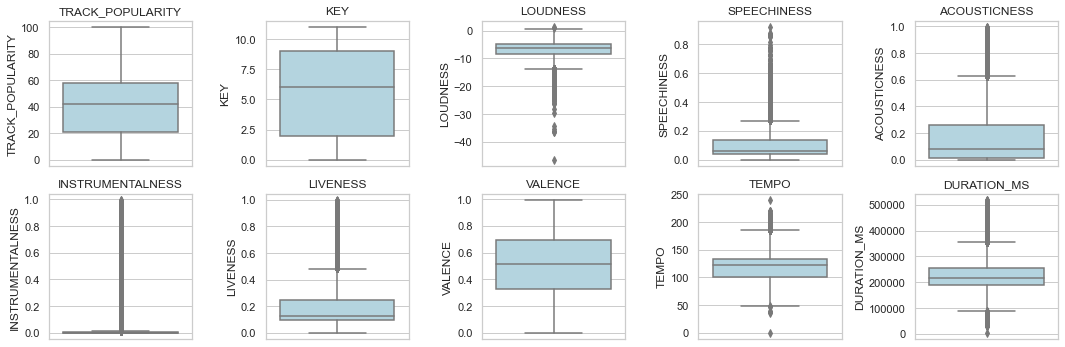

In [49]:
# Create boxplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(features):
    sns.boxplot(y=features[col], ax=axes[i], color='lightblue')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Some variables have a lot of outliers.

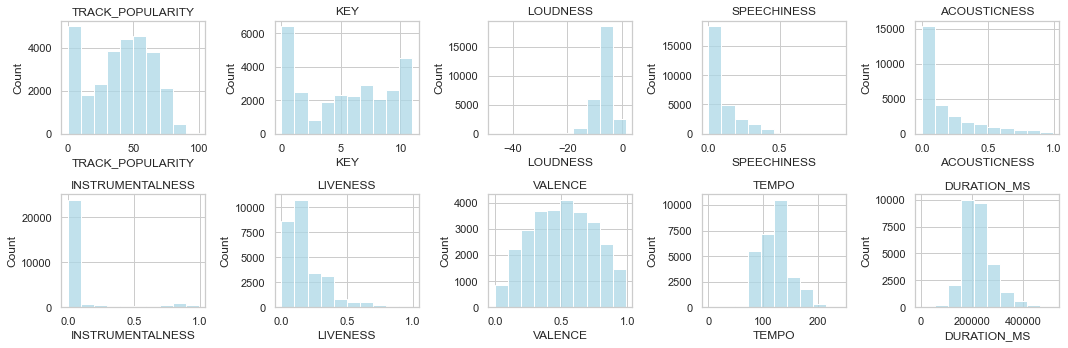

In [50]:
# create histograms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(features):
    sns.histplot(features[col], bins=10, kde=False, ax=axes[i], color='lightblue')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Some variables have a fairly normal distribution.

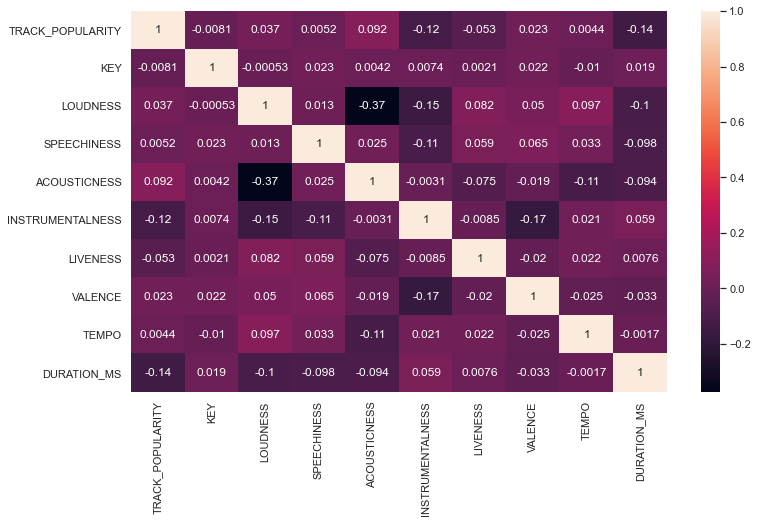

In [51]:
# heatmap to check for any relationships
plt.figure(figsize=(12,7))
sns.heatmap(features.corr(),annot=True,)
plt.show()

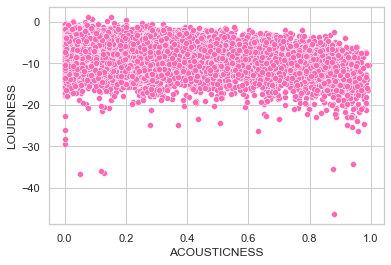

In [52]:
# Observe some relationships with scatterplots based on the heatmap above

sns.scatterplot(data = features, x = 'ACOUSTICNESS', y = 'LOUDNESS', color='hotpink')
plt.show()

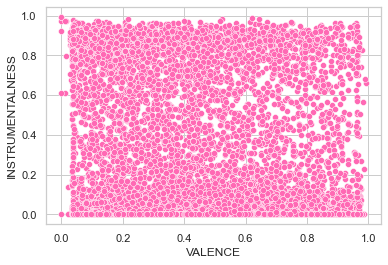

In [53]:
sns.scatterplot(data = features, x = 'VALENCE', y = 'INSTRUMENTALNESS', color='hotpink')
plt.show()

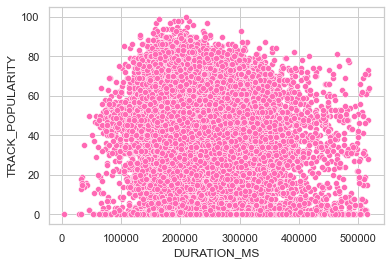

In [54]:
sns.scatterplot(data = features, x = 'DURATION_MS', y = 'TRACK_POPULARITY', color='hotpink')
plt.show()

Not able to see any obvious clusters or relationships due to the amount of datapoints. 

### 5. Reducing the Dataset
Due to the number of rows and the amount of potential features that could be included in the K-means algorithm, the cost/run time of the algorithm could be too high. Therefore, the dataset will be reduced and 2 features will be selected to allow for reduced cost/run time and easier visualisation. I will select variables with few outliers and a fairly normal distribution.

In [55]:
# reduce the original dataset to include only the top 1000 most popular songs
reduced_dataset = df.sort_values(by=['TRACK_POPULARITY'], ascending=False).head(1000)
reduced_dataset.describe().round(2)

,TRACK_POPULARITY,DANCEABILITY,ENERGY,KEY,LOUDNESS,MODE,SPEECHINESS,ACOUSTICNESS,INSTRUMENTALNESS,LIVENESS,VALENCE,TEMPO,DURATION_MS
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,80.96,0.68,0.65,5.32,-6.10,0.58,0.12,0.22,0.01,0.17,0.51,121.36,212477.36
std,4.34,0.14,0.17,3.66,2.62,0.49,0.11,0.23,0.07,0.13,0.22,29.36,46088.27
min,76.00,0.15,0.06,0.00,-23.02,0.00,0.02,0.00,0.00,0.02,0.04,48.72,104591.00
25%,78.00,0.59,0.54,2.00,-7.23,0.00,0.04,0.04,0.00,0.09,0.34,97.91,181972.75
50%,80.00,0.70,0.67,5.00,-5.71,1.00,0.07,0.13,0.00,0.12,0.52,118.94,206955.00
75%,83.00,0.78,0.78,9.00,-4.39,1.00,0.15,0.32,0.00,0.19,0.69,140.03,233668.75
max,100.00,0.97,0.99,11.00,0.30,1.00,0.86,0.95,0.81,0.96,0.97,205.27,484147.00


Here we have checked that the dataset has been reduced to 1000 rows.

In [56]:
# select the new reduced number of features from the original df, this time ensuring we have track id, name, and artist name
new_features = reduced_dataset[['TRACK_ID','TRACK_NAME','TRACK_ARTIST','VALENCE','TEMPO']]
new_features = pd.DataFrame(new_features)
new_features.head()

,TRACK_ID,TRACK_NAME,TRACK_ARTIST,VALENCE,TEMPO
1551,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Tones and I,0.513,98.027
20092,696DnlkuDOXcMAnKlTgXXK,ROXANNE,Arizona Zervas,0.457,116.735
1301,21jGcNKet2qwijlDFuPiPb,Circles,Post Malone,0.553,120.042
5508,0nbXyq5TXYPCO7pr3N8S4I,The Box,Roddy Ricch,0.642,116.971
711,2b8fOow8UzyDFAE27YhOZM,Memories,Maroon 5,0.575,91.019


In [57]:
# remove outliers
Q1 = new_features['TEMPO'].quantile(0.25)
Q3 = new_features['TEMPO'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
features_filtered = new_features[(new_features['TEMPO'] >= lower_bound) & (new_features['TEMPO'] <= upper_bound)].copy()

features_filtered.describe().round(2)

,VALENCE,TEMPO
count,999.00,999.00
mean,0.52,121.27
std,0.22,29.25
min,0.04,48.72
25%,0.34,97.87
50%,0.52,118.92
75%,0.69,140.02
max,0.97,197.70


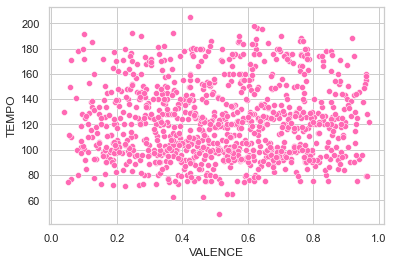

In [58]:
# examine the relationship
sns.scatterplot(data = new_features, x = 'VALENCE', y = 'TEMPO', color='hotpink')
plt.show()

### 6. Standardising the Data

#### Z-Score Normalisation.

In [59]:
# scale the data
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(new_features[['VALENCE','TEMPO']].copy())
data_scaled = pd.DataFrame(data_scaled, columns = ['VALENCE','TEMPO'])
data_scaled = pd.concat([data_scaled.copy(), new_features[['TRACK_ID','TRACK_NAME','TRACK_ARTIST']].copy().reset_index(drop=True)], axis=1)
data_scaled.head()

,VALENCE,TEMPO,TRACK_ID,TRACK_NAME,TRACK_ARTIST
0,-0.008563,-0.795065,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Tones and I
1,-0.259388,-0.157516,696DnlkuDOXcMAnKlTgXXK,ROXANNE,Arizona Zervas
2,0.170597,-0.044817,21jGcNKet2qwijlDFuPiPb,Circles,Post Malone
3,0.569229,-0.149474,0nbXyq5TXYPCO7pr3N8S4I,The Box,Roddy Ricch
4,0.269136,-1.033890,2b8fOow8UzyDFAE27YhOZM,Memories,Maroon 5


In [60]:
# check that the scaling worked (mean should be 0, std dv should be 1)
data_scaled.describe().round(2)

,VALENCE,TEMPO
count,1000.00,1000.00
mean,0.00,0.00
std,1.00,1.00
min,-2.13,-2.48
25%,-0.76,-0.80
50%,0.01,-0.08
75%,0.78,0.64
max,2.03,2.86


### 7. Creating Initial Clusters

In [61]:
# create initial clusters using a random number
from sklearn.cluster import KMeans 
km = KMeans(n_clusters = 10, n_init = 50, random_state = 123)
km.fit(data_scaled[["VALENCE", "TEMPO"]])

KMeans(n_clusters=10, n_init=50, random_state=123)

In [62]:
# look at the inertia value
km.inertia_

231.6634383504586

This inertia value is not that close to 0 so perhaps 10 is not the correct number of clusters. I will visually inspect the clusters and explore the correct number of clusters later using the elbow method and the silhouette score. 

### 6. Evaluating the Clusters

In [63]:
# check the number of datapoints per cluster
pd.Series(km.labels_).value_counts().sort_index()

0    110
1    128
2     44
3     65
4    130
5    138
6     92
7     82
8    128
9     83
dtype: int64

Some clusters have significantly more datapoints than others, suggesting that 10 might not be enough.

#### Visually Inspecting the Clusters

In [64]:
# check the coordinates of the clusters
km.cluster_centers_

array([[ 1.29617303,  0.16614495],
       [ 0.11719927,  0.12732417],
       [-1.22736303,  1.6867718 ],
       [ 1.20745415,  1.56727573],
       [-0.55314184, -0.93130948],
       [ 0.32359791, -0.93133089],
       [-1.51436763, -0.74646573],
       [ 0.07795842,  1.57191087],
       [-1.02811892,  0.44290613],
       [ 1.32191925, -0.93956932]])

In [65]:
# convert the array above to a dataframe for easier inspection
cluster_centres = pd.DataFrame(km.cluster_centers_, columns = ['VALENCE','TEMPO'])
cluster_centres 

,VALENCE,TEMPO
0,1.296173,0.166145
1,0.117199,0.127324
2,-1.227363,1.686772
3,1.207454,1.567276
4,-0.553142,-0.931309
5,0.323598,-0.931331
6,-1.514368,-0.746466
7,0.077958,1.571911
8,-1.028119,0.442906
9,1.321919,-0.939569


The data has been scaled so the mean is 0. This helps us form a visual of where the clusters might be on a plot.

In [66]:
# append the new clusters to our dataframe to see which songs are in which cluster
data_scaled["Cluster"] = km.labels_

In [67]:
data_scaled.head(50)

,VALENCE,TEMPO,TRACK_ID,TRACK_NAME,TRACK_ARTIST,Cluster
0,-0.008563,-0.795065,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Tones and I,5
1,-0.259388,-0.157516,696DnlkuDOXcMAnKlTgXXK,ROXANNE,Arizona Zervas,1
2,0.170597,-0.044817,21jGcNKet2qwijlDFuPiPb,Circles,Post Malone,1
3,0.569229,-0.149474,0nbXyq5TXYPCO7pr3N8S4I,The Box,Roddy Ricch,1
4,0.269136,-1.033890,2b8fOow8UzyDFAE27YhOZM,Memories,Maroon 5,5
5,0.264657,-0.690852,7k4t7uLgtOxPwTpFmtJNTY,Tusa,KAROL G,5
6,-0.761037,1.692355,0sf12qNH5qcw8qpgymFOqD,Blinding Lights,The Weeknd,2
7,-1.217896,-0.046044,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,Billie Eilish,8
8,-1.249249,0.195268,4TnjEaWOeW0eKTKIEvJyCa,Falling,Trevor Daniel,8
9,0.725995,0.088056,6WrI0LAC5M1Rw2MnX2ZvEg,Don't Start Now,Dua Lipa,0


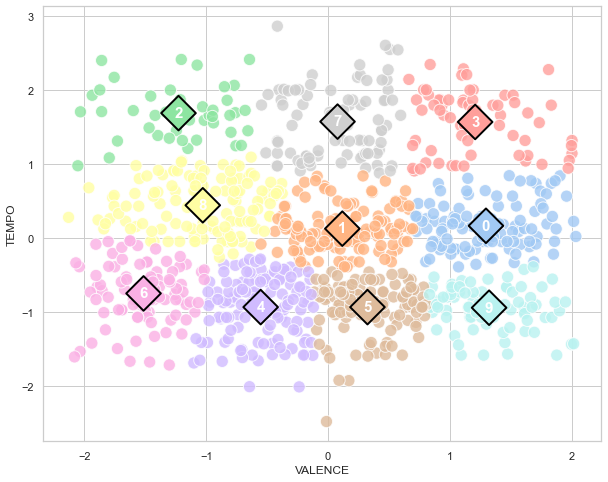

In [68]:
# plotting the clusters and centroids
# set fig size
plt.figure(figsize = (10, 8))

# plot clusters
ax = sns.scatterplot(data = data_scaled,
                    x = 'VALENCE',
                    y = 'TEMPO',
                    hue = 'Cluster',
                    palette = 'pastel',
                    alpha = 0.8,
                    s = 150,
                    legend = False)
# plot centroids
ax = sns.scatterplot(data = cluster_centres,
                    x = 'VALENCE',
                    y = 'TEMPO',
                    hue = cluster_centres.index,
                    palette = 'pastel',
                    s = 600,
                    marker = 'D',
                    ec = 'black',
                    legend = False)

# add centroid labels 
for i in range(len(cluster_centres)):
    plt.text(x = cluster_centres.VALENCE[i],
            y = cluster_centres.TEMPO[i],
            s = i,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            size = 15,
            weight = 'bold',
            color = 'white')

Earlier inspection suggested that some clusters appeared to be bigger than others, suggesting that these clusters might need evaluating. However, upon inspection, these clusters do not appear to be unusual. They appear to be quite evenly spread, though some have more datapoints than others.

### 7. Evaluating the Number of Clusters

#### Elbow Method

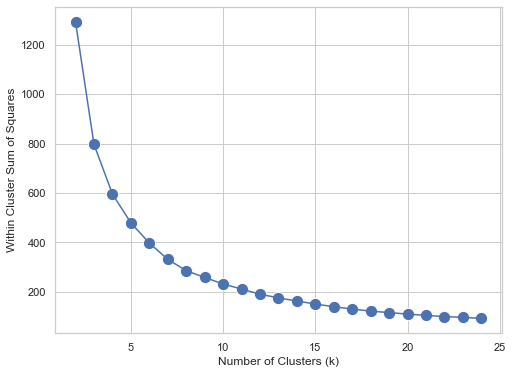

In [69]:
elbow = []
for k in range(2, 25):
    km = KMeans(n_clusters = k, n_init = 50, random_state=123)
    km.fit(data_scaled[['VALENCE','TEMPO']])
    elbow.append(km.inertia_)

elbow_series = pd.Series(elbow, index = range(2, 25))

plt.figure(figsize=(8,6))
ax = sns.lineplot(y=elbow_series, x=elbow_series.index)
ax = sns.scatterplot(y=elbow_series, x=elbow_series.index, s=150)
ax = ax.set(xlabel = 'Number of Clusters (k)',
           ylabel = 'Within Cluster Sum of Squares')
plt.show()

There appears to be no clear 'elbow' in the plot and it is not clear where exactly the data levels off. The ideal number of clusters could anywhere after 10.

#### Silhouette Score

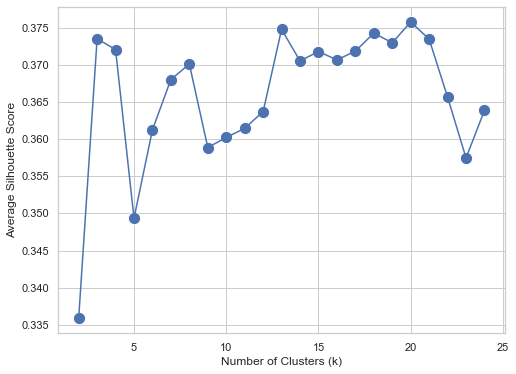

In [70]:
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 25):
    km = KMeans(n_clusters = k, n_init = 50, random_state = 123)
    km.fit(data_scaled[['VALENCE','TEMPO']])
    silhouette.append(silhouette_score(data_scaled[['VALENCE','TEMPO']], km.labels_))

silhouette_series = pd.Series(silhouette, index = range(2, 25))

plt.figure(figsize = (8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s=150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
           ylabel = 'Average Silhouette Score')

Though there are several peaks, 20 appears to be the highest and therefore most ideal number of clusters. The elbow method also suggested that the ideal number of clusters could be anywhere from 10 onwards, so I will set k = 20.

### 8. Results

In [76]:
# re-fit the model using the new k value.
km = KMeans(n_clusters = 20, n_init = 50, random_state = 123)
km.fit(data_scaled[["VALENCE", "TEMPO"]].copy())

KMeans(n_clusters=20, n_init=50, random_state=123)

In [77]:
# assign the songs to their new clusters
data_scaled["Cluster"] = km.labels_
data_scaled.head(50)

,VALENCE,TEMPO,TRACK_ID,TRACK_NAME,TRACK_ARTIST,Cluster
0,-0.008563,-0.795065,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Tones and I,17
1,-0.259388,-0.157516,696DnlkuDOXcMAnKlTgXXK,ROXANNE,Arizona Zervas,0
2,0.170597,-0.044817,21jGcNKet2qwijlDFuPiPb,Circles,Post Malone,0
3,0.569229,-0.149474,0nbXyq5TXYPCO7pr3N8S4I,The Box,Roddy Ricch,7
4,0.269136,-1.033890,2b8fOow8UzyDFAE27YhOZM,Memories,Maroon 5,17
5,0.264657,-0.690852,7k4t7uLgtOxPwTpFmtJNTY,Tusa,KAROL G,17
6,-0.761037,1.692355,0sf12qNH5qcw8qpgymFOqD,Blinding Lights,The Weeknd,11
7,-1.217896,-0.046044,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,Billie Eilish,13
8,-1.249249,0.195268,4TnjEaWOeW0eKTKIEvJyCa,Falling,Trevor Daniel,13
9,0.725995,0.088056,6WrI0LAC5M1Rw2MnX2ZvEg,Don't Start Now,Dua Lipa,7


In [78]:
cluster_centres = pd.DataFrame(km.cluster_centers_, columns = ['VALENCE','TEMPO'])

In [79]:
# set a colour palette for 20 colours
colours = ["#d3d3d3", "#2f4f4f", "#2e8b57", "#7f0000", "#808000", "#483d8b", "#ff0000", "#ff8c00", "#ffd700", "#0000cd", "#ba55d3", "#00ff7f", "#00bfff", "#adff2f", "#ff00ff", "#f0e68c", "#dda0dd", "#ff1493", "#ffa07a", "#7fffd4"]

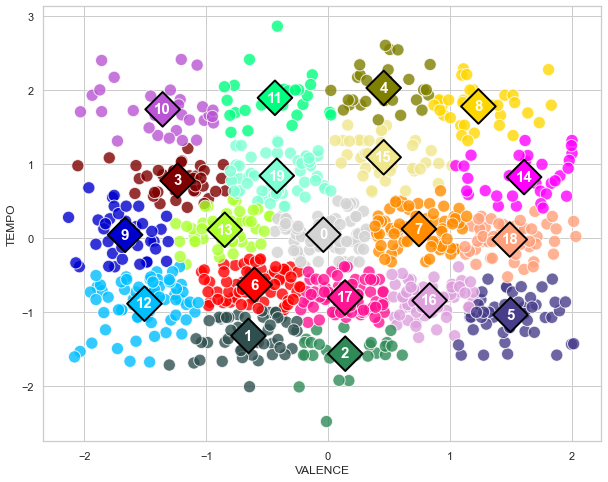

In [80]:
# set fig size
plt.figure(figsize = (10, 8))

# plot clusters
ax = sns.scatterplot(data = data_scaled,
                    x = 'VALENCE',
                    y = 'TEMPO',
                    hue = 'Cluster',
                    palette = colours,
                    alpha = 0.8,
                    s = 150,
                    legend = False)

# plot centroids
ax = sns.scatterplot(data = cluster_centres,
                    x = 'VALENCE',
                    y = 'TEMPO',
                    hue = cluster_centres.index,
                    palette = colours,
                    s = 600,
                    marker = 'D',
                    ec = 'black',
                    legend = False)

# add centroid labels 
for i in range(len(cluster_centres)):
    plt.text(x = cluster_centres.VALENCE[i],
            y = cluster_centres.TEMPO[i],
            s = i,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            size = 15,
            weight = 'bold',
            color = 'white')